# Project 2020 Machine Learning and Statistics
***

### Instructions
In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. Your submission must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that trains a model using the data set. In the notebook you should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README.

To enhance your submission, you might consider developing and comparing more than one model. Rest assured, all the above concepts will be explored in lecture videos and other materials in the coming semester.


### Wind Power
Wind power is the generation of electricity from wind. Wind power harvests the primary energy flow of the atmosphere generated from the uneven heating of the Earth’s surface by the Sun. Therefore, wind power is an indirect way to harness solar energy. Wind power is converted to electrical energy by wind turbines.

### Wind Speed Vs Power

Wind speed largely determines the amount of electricity generated by a turbine. Higher wind speeds generate more power because stronger winds allow the blades to rotate faster. Faster rotation translates to more mechanical power and more electrical power from the generator. The relationship between wind speed and power for a typical wind turbine is shown below

![title](images/Windpowercurve.png)

Turbines are designed to operate within a specific range of wind speeds. The limits of the range are known as the cut-in speed and cut-out speed.The cut-in speed is the point at which the wind turbine is able to generate power. Between the cut-in speed and the rated speed, where the maximum output is reached.

The cut-out speed is the point at which the turbine must be shut down to avoid damage to the equipment. The cut-in and cut-out speeds are related to the turbine design and size and are decided on prior to construction

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import sklearn.cluster as skcl
import tensorflow as tf
from tensorflow import keras as kr
import sklearn.preprocessing as pre
import sklearn.model_selection as mod

#Read in powerproduction csv file from github url
df = pd.read_csv("https://raw.githubusercontent.com/EoinStankard/Machine-Learning-Statistics-Project/main/powerproduction.csv")
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [2]:
# description of the dataset given including max min and average speed and power
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


#### Wind speed Vs Power with our data

Plotting wind speed vs power usinf the data given for this assingment
Below is a scatter plot shown in blue wit the best fit line shown in red

<AxesSubplot:xlabel='speed', ylabel='power'>

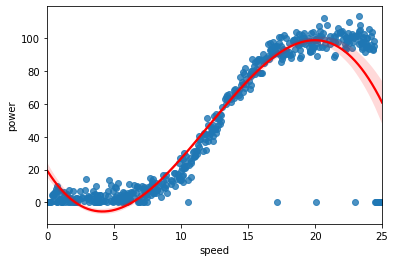

In [3]:
sns.regplot(x="speed", y="power", data=df,order=3,label ="order=3", line_kws={"color": "red"})

#### Plotting values by speed

In [4]:
#sorting the dataset by speed so they can then be divided up into groups
df.sort_values(by='speed', ascending=True).head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


Below is a scatter plot of three different speed ranges, 0-10,10-20 and 25+

In [5]:
lowspeed = df[(df["speed"] >= 0) & (df["speed"]<=10)] # low speed between 0-10
medspeed= df[(df["speed"] > 10) & (df["speed"]<=20)] # Medium speed between 10-20
highspeed=df[(df["speed"] > 20)] # High speed between 20+

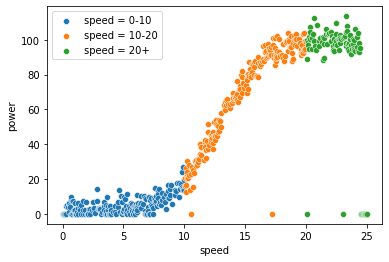

In [6]:
sns.scatterplot(x="speed", y="power", data=lowspeed,label ="speed = 0-10")
sns.scatterplot(x="speed", y="power", data=medspeed,label ="speed = 10-20")
sns.scatterplot(x="speed", y="power", data=highspeed,label ="speed = 20+")
plt.legend()

In [7]:
speedData = [["0-10",lowspeed['power'].min(),lowspeed['power'].max(),lowspeed['power'].mean()],
            ["10-20",medspeed['power'].min(),medspeed['power'].max(),medspeed['power'].mean()],
            ["20+",highspeed['power'].min(),highspeed['power'].max(),highspeed['power'].mean()],]

print("\nPower outputs for each speed group, 0-10, 10-20 & 20+")
pd.DataFrame(speedData, columns=["Speed","Min pwr", "Max pwr","Mean pwr"])



Power outputs for each speed group, 0-10, 10-20 & 20+


,Speed,Min pwr,Max pwr,Mean pwr
0,0-10,0.0,27.136,5.405267
1,10-20,0.0,104.188,69.654178
2,20+,0.0,113.556,87.270062


#### Plotting values by power

In [8]:
lowpower = df[(df["power"] >= 0) & (df["power"] < 40)] # low speed between 0-10
medpower= df[(df["power"] >= 39) & (df["power"] <80)] # Medium speed between 10-20
highpower=df[(df["power"] >= 80)] # High speed between 20+

<AxesSubplot:xlabel='speed', ylabel='power'>

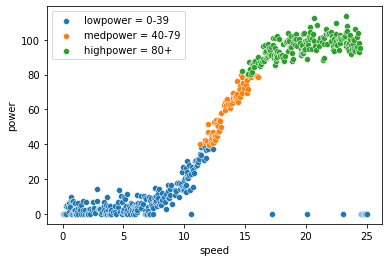

In [9]:
sns.scatterplot(x="speed", y="power", data=lowpower,label ="lowpower = 0-39")
sns.scatterplot(x="speed", y="power", data=medpower,label ="medpower = 40-79")
sns.scatterplot(x="speed", y="power", data=highpower,label ="highpower = 80+")

In [10]:
speedData = [["0-39",lowpower['speed'].min(),lowpower['speed'].max(),lowpower['speed'].mean()],
            ["40-79",medpower['speed'].min(),medpower['speed'].max(),medpower['speed'].mean()],
            ["80+",highpower['speed'].min(),highpower['speed'].max(),highpower['speed'].mean()],]

print("Speed outputs for each power group, 0-39, 40-79 & 80+")
pd.DataFrame(speedData, columns=["Power","Min sp", "Max sp","Mean sp"])

Speed outputs for each power group, 0-39, 40-79 & 80+


,Power,Min sp,Max sp,Mean sp
0,0-39,0.000,25.000,6.852305
1,40-79,11.311,16.041,13.614986
2,80+,14.765,24.399,19.897760


## Preforming K-Means fitting
***

Here i will preform kmeans fitting where i will set the function to automatically divide the data into three clusters, I will then display the data on a graph like above

In [11]:
# Perform kmeans fitting.
X = df[['speed', 'power']].to_numpy()
kmeans = skcl.KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2,

Plot the three clusters that Kmeans has calculated

Text(0, 0.5, 'Power')

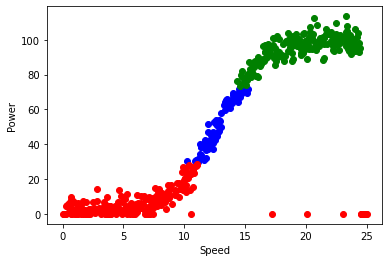

In [12]:
# Plot the data set.
plt.plot(X[kmeans.labels_ == 0][:,0], X[kmeans.labels_ == 0][:,1], 'bo')
plt.plot(X[kmeans.labels_ == 1][:,0], X[kmeans.labels_ == 1][:,1], 'ro')
plt.plot(X[kmeans.labels_ == 2][:,0], X[kmeans.labels_ == 2][:,1], 'go')
plt.xlabel("Speed")
plt.ylabel("Power")

Get the centerpoint of each cluster

In [13]:
# The centres of clusters.
mycent = kmeans.cluster_centers_
mycent

array([[12.79975342, 51.26269863],
       [ 6.51265939,  6.53523581],
       [19.54251515, 94.79063636]])

Plot the graph once again with the center points of each cluster marked with an 'x'

Text(0, 0.5, 'Power')

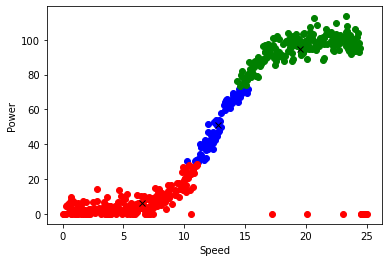

In [14]:
plt.plot(X[kmeans.labels_ == 0][:,0], X[kmeans.labels_ == 0][:,1], 'bo')
plt.plot(X[kmeans.labels_ == 1][:,0], X[kmeans.labels_ == 1][:,1], 'ro')
plt.plot(X[kmeans.labels_ == 2][:,0], X[kmeans.labels_ == 2][:,1], 'go')
plt.plot(mycent[:,0], mycent[:,1], 'kx')
plt.xlabel("Speed")
plt.ylabel("Power")

## Linear Regression
***

#### Line of best Fit
Find the line of best fit and plot it with all the data points

In [15]:
x = df["speed"]
y = df["power"]
l = np.linspace(x.min(), x.max(), len(x))
np.polyfit(x, y, 1)

array([  4.91759567, -13.89990263])

In [16]:
# Create variables with those values.
m, c = np.polyfit(x, y, 1)
# Have a look at m and c.
m, c

(4.917595665404667, -13.899902630519604)

Text(0, 0.5, 'Power')

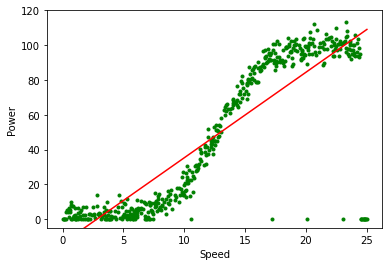

In [17]:
# Plot x and y and the regression line in red.
plt.plot(x, y, 'g.')
plt.plot(x, m * x + c, 'r-')
plt.ylim([-5.0, 120.0]);
plt.xlabel("Speed")
plt.ylabel("Power")

## Neural Networks

https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-linear.ipynb

https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-and-iris.ipynb

https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb

In [46]:
# Split the inputs and outputs into training and test sets.
inputs_train, inputs_test, outputs_train, outputs_test = mod.train_test_split(df['speed'], df['power'], test_size=0.2)

In [47]:
# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [48]:
# Fit the data.
model.fit(inputs_train, outputs_train, epochs=500)

Epoch 1/500
400/400 [==============================] - 0s 460us/sample - loss: 4181.5654
Epoch 2/500
400/400 [==============================] - 0s 37us/sample - loss: 4131.8124
Epoch 3/500
400/400 [==============================] - 0s 40us/sample - loss: 4083.1131
Epoch 4/500
400/400 [==============================] - 0s 40us/sample - loss: 4035.2654
Epoch 5/500
400/400 [==============================] - 0s 40us/sample - loss: 3987.8879
Epoch 6/500
400/400 [==============================] - 0s 40us/sample - loss: 3938.6666
Epoch 7/500
400/400 [==============================] - 0s 40us/sample - loss: 3888.3324
Epoch 8/500
400/400 [==============================] - 0s 37us/sample - loss: 3834.6049
Epoch 9/500
400/400 [==============================] - 0s 40us/sample - loss: 3778.7079
Epoch 10/500
400/400 [==============================] - 0s 40us/sample - loss: 3718.7897
Epoch 11/500
400/400 [==============================] - 0s 37us/sample - loss: 3652.2478
Epoch 12/500
400/400 [=======

400/400 [==============================] - 0s 40us/sample - loss: 1433.4497
Epoch 94/500
400/400 [==============================] - ETA: 0s - loss: 1505.70 - 0s 40us/sample - loss: 1420.2988
Epoch 95/500
400/400 [==============================] - 0s 42us/sample - loss: 1407.5423
Epoch 96/500
400/400 [==============================] - 0s 40us/sample - loss: 1394.4758
Epoch 97/500
400/400 [==============================] - 0s 37us/sample - loss: 1381.7389
Epoch 98/500
400/400 [==============================] - 0s 40us/sample - loss: 1369.0846
Epoch 99/500
400/400 [==============================] - 0s 40us/sample - loss: 1356.5127
Epoch 100/500
400/400 [==============================] - 0s 40us/sample - loss: 1344.1776
Epoch 101/500
400/400 [==============================] - 0s 37us/sample - loss: 1331.7630
Epoch 102/500
400/400 [==============================] - 0s 35us/sample - loss: 1319.8884
Epoch 103/500
400/400 [==============================] - 0s 35us/sample - loss: 1307.5378
Epoc

400/400 [==============================] - 0s 43us/sample - loss: 631.0048
Epoch 185/500
400/400 [==============================] - 0s 43us/sample - loss: 626.1373
Epoch 186/500
400/400 [==============================] - 0s 45us/sample - loss: 621.1834
Epoch 187/500
400/400 [==============================] - 0s 43us/sample - loss: 616.0034
Epoch 188/500
400/400 [==============================] - 0s 45us/sample - loss: 611.2913
Epoch 189/500
400/400 [==============================] - 0s 32us/sample - loss: 606.7106
Epoch 190/500
400/400 [==============================] - 0s 38us/sample - loss: 601.5241
Epoch 191/500
400/400 [==============================] - 0s 38us/sample - loss: 597.1900
Epoch 192/500
400/400 [==============================] - 0s 35us/sample - loss: 592.8880
Epoch 193/500
400/400 [==============================] - 0s 42us/sample - loss: 587.9991
Epoch 194/500
400/400 [==============================] - 0s 37us/sample - loss: 583.5486
Epoch 195/500
400/400 [============

Epoch 276/500
400/400 [==============================] - 0s 55us/sample - loss: 378.2846
Epoch 277/500
400/400 [==============================] - 0s 52us/sample - loss: 377.3063
Epoch 278/500
400/400 [==============================] - 0s 50us/sample - loss: 375.8964
Epoch 279/500
400/400 [==============================] - 0s 50us/sample - loss: 374.8712
Epoch 280/500
400/400 [==============================] - 0s 52us/sample - loss: 374.1447
Epoch 281/500
400/400 [==============================] - 0s 50us/sample - loss: 372.5202
Epoch 282/500
400/400 [==============================] - 0s 42us/sample - loss: 371.7187
Epoch 283/500
400/400 [==============================] - 0s 35us/sample - loss: 370.6399
Epoch 284/500
400/400 [==============================] - 0s 35us/sample - loss: 369.4222
Epoch 285/500
400/400 [==============================] - 0s 33us/sample - loss: 368.6446
Epoch 286/500
400/400 [==============================] - 0s 27us/sample - loss: 367.3552
Epoch 287/500
400/400

400/400 [==============================] - 0s 32us/sample - loss: 322.3239
Epoch 369/500
400/400 [==============================] - 0s 38us/sample - loss: 322.0672
Epoch 370/500
400/400 [==============================] - 0s 33us/sample - loss: 322.0537
Epoch 371/500
400/400 [==============================] - 0s 32us/sample - loss: 321.6359
Epoch 372/500
400/400 [==============================] - 0s 35us/sample - loss: 321.0284
Epoch 373/500
400/400 [==============================] - 0s 35us/sample - loss: 320.6247
Epoch 374/500
400/400 [==============================] - 0s 37us/sample - loss: 320.5356
Epoch 375/500
400/400 [==============================] - 0s 33us/sample - loss: 320.3846
Epoch 376/500
400/400 [==============================] - 0s 33us/sample - loss: 319.8713
Epoch 377/500
400/400 [==============================] - 0s 33us/sample - loss: 319.6940
Epoch 378/500
400/400 [==============================] - 0s 32us/sample - loss: 319.4871
Epoch 379/500
400/400 [============

400/400 [==============================] - 0s 37us/sample - loss: 301.3875
Epoch 461/500
400/400 [==============================] - 0s 35us/sample - loss: 301.2700
Epoch 462/500
400/400 [==============================] - 0s 35us/sample - loss: 301.2597
Epoch 463/500
400/400 [==============================] - 0s 30us/sample - loss: 300.6236
Epoch 464/500
400/400 [==============================] - 0s 32us/sample - loss: 300.5503
Epoch 465/500
400/400 [==============================] - 0s 35us/sample - loss: 300.4869
Epoch 466/500
400/400 [==============================] - 0s 35us/sample - loss: 300.1173
Epoch 467/500
400/400 [==============================] - 0s 35us/sample - loss: 299.8042
Epoch 468/500
400/400 [==============================] - 0s 32us/sample - loss: 299.5281
Epoch 469/500
400/400 [==============================] - 0s 32us/sample - loss: 299.5912
Epoch 470/500
400/400 [==============================] - 0s 35us/sample - loss: 299.2751
Epoch 471/500
400/400 [============

In [52]:
model.predict([5])

array([[1.7202296]], dtype=float32)

## References

1. https://energyeducation.ca/encyclopedia/Wind_power#:~:text=Wind%20speed%20largely%20determines%20the,electrical%20power%20from%20the%20generator.

2. https://seaborn.pydata.org/generated/seaborn.regplot.html
3. https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
4. https://seaborn.pydata.org/generated/seaborn.scatterplot.html
5. https://seaborn.pydata.org/generated/seaborn.regplot.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
7. https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb
8. https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/kmeans-examples.ipynb


# END